In [21]:
import sys
sys.path.append("../")
sys.path.append("../src")
from tqdm import tqdm, trange
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity

# Load Models

In [2]:
from src.llama2 import Llama2
from src.nlp_base import NLP_base
from src.nlp_langchain import NLP_langchain
from src.openai import OpenAI

openai

In [3]:
openai = OpenAI(
    input_files=["../data/pdf/am-mid-year-outlook-2024.pdf"],
    verbose=False, 
); openai.train()

llama2

In [4]:
llama2 = Llama2(
    input_files=["../data/pdf/am-mid-year-outlook-2024.pdf"],
    verbose=False,
); llama2.train()

nlp-base

In [5]:
nlp_base = NLP_base(
    input_files=["../data/pdf/am-mid-year-outlook-2024.pdf"],
    verbose=False,
); nlp_base.train()

nlp-langchain

In [6]:
nlp_langchain = NLP_langchain(
    input_files=["../data/pdf/am-mid-year-outlook-2024.pdf"],
    verbose=False,
); nlp_langchain.train()

# load Manual Labeled Data

In [7]:
questions = pd.read_csv("../data/testQ.csv")

In [ ]:
def test_model(model):
    sim_q_r, sim_a_r = [], []
    iterator = questions[["Question", "Answer"]].to_records(index=False)
    for q, a in tqdm(iterator):
        scores_q, scores_a = [], []
        for _ in range(10):
            response, score = model.answer(q)
            scores_q.append(score)
            scores_a.append(cosine_similarity(
                [model.embed_model._embed(a)], 
                [model.embed_model._embed(str(response))],
            )[0][0])
        sim_q_r.append(np.mean(scores_q))
        sim_a_r.append(np.mean(scores_a))
    res = questions[["Question"]].copy()
    res["similarity_response_question"] = sim_q_r
    res["similarity_response_answer"] = sim_a_r
    return res

In [9]:
# res_openai = test_model(openai)
# res_openai["model"] = "openai"
#* to save API usage
res_openai = pd.read_csv("./test_results.csv")[lambda x: x.model == "openai"]

res_llama2 = test_model(llama2)
res_llama2["model"] = "llama2"

res_nlp_base = test_model(nlp_base)
res_nlp_base["model"] = "nlp_base"

res_nlp_langchain = test_model(nlp_langchain)
res_nlp_langchain["model"] = "nlp_langchain"

In [10]:
sim_q_r, sim_a_r = [], []
iterator = questions[["Question", "Answer"]].to_records(index=False)
for q, a in tqdm(iterator):
    scores_q, scores_a = [], []
    for _ in range(10):
        response, score = llama2.answer(q)
        scores_q.append(score)
        scores_a.append(cosine_similarity(
            [llama2.embed_model._embed(a)], 
            [llama2.embed_model._embed(str(response))],
        )[0][0])
    sim_q_r.append(np.mean(scores_q))
    sim_a_r.append(np.mean(scores_a))

100%|██████████| 15/15 [22:06<00:00, 88.43s/it] 


In [11]:
res_llama2 = questions[["Question"]].copy()
res_llama2["model"] = "llama2"
res_llama2["similarity_response_question"] = sim_q_r
res_llama2["similarity_response_answer"] = sim_a_r

In [12]:
sim_q_r, sim_a_r = [], []
iterator = questions[["Question", "Answer"]].to_records(index=False)
for q, a in tqdm(iterator):
    scores_q, scores_a = [], []
    for _ in range(10):
        response, score = nlp_base.answer(q)
        scores_q.append(score)
        scores_a.append(cosine_similarity(
            [nlp_base.embed_model._embed(a)], 
            [nlp_base.embed_model._embed(str(response))],
        )[0][0])
    sim_q_r.append(np.mean(scores_q))
    sim_a_r.append(np.mean(scores_a))

100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


In [13]:
res_nlp_base = questions[["Question"]].copy()
res_nlp_base["model"] = "nlp_base"
res_nlp_base["similarity_response_question"] = sim_q_r
res_nlp_base["similarity_response_answer"] = sim_a_r

In [14]:
sim_q_r, sim_a_r = [], []
iterator = questions[["Question", "Answer"]].to_records(index=False)
for q, a in tqdm(iterator):
    scores_q, scores_a = [], []
    for _ in range(10):
        response, score = nlp_langchain.answer(q)
        scores_q.append(score)
        scores_a.append(cosine_similarity(
            [nlp_langchain.embed_model._embed(a)], 
            [nlp_langchain.embed_model._embed(str(response))],
        )[0][0])
    sim_q_r.append(np.mean(scores_q))
    sim_a_r.append(np.mean(scores_a))

100%|██████████| 15/15 [00:18<00:00,  1.21s/it]


In [15]:
res_nlp_langchain = questions[["Question"]].copy()
res_nlp_langchain["model"] = "nlp_langchain"
res_nlp_langchain["similarity_response_question"] = sim_q_r
res_nlp_langchain["similarity_response_answer"] = sim_a_r

merge and save results

In [33]:
res = pd.concat([res_openai, res_llama2, res_nlp_base, res_nlp_langchain])
res.sort_values(["Question", "model"], inplace=True, ignore_index=True)
res.to_csv("./test_results.csv", index=False)

Interpretation of Columns
- `similarity_response_answer`: cosine similarity between response and manually labeled answer
- `similarity_response_question`: cosine similarity between response and input question

In [34]:
res

,Question,model,similarity_response_question,similarity_response_answer
0,Are investment theses predicated on the contin...,llama2,0.851949,0.845337
1,Are investment theses predicated on the contin...,nlp_base,0.728865,0.784294
2,Are investment theses predicated on the contin...,nlp_langchain,0.771549,0.846241
3,Are investment theses predicated on the contin...,openai,0.887849,0.931011
4,Can small caps finally outperform?,llama2,0.792853,0.859005
5,Can small caps finally outperform?,nlp_base,0.668756,0.796996
6,Can small caps finally outperform?,nlp_langchain,0.987049,0.932814
7,Can small caps finally outperform?,openai,0.870086,0.982273
8,How much has Norway's policy rate changed over...,llama2,0.851271,0.602817
9,How much has Norway's policy rate changed over...,nlp_base,0.682312,0.595814


In [49]:
res.iloc[:, 1:].groupby("model").mean()

,similarity_response_question,similarity_response_answer
model,,
llama2,0.850191,0.832461
nlp_base,0.745984,0.785606
nlp_langchain,0.870322,0.831770
openai,0.905146,0.932095


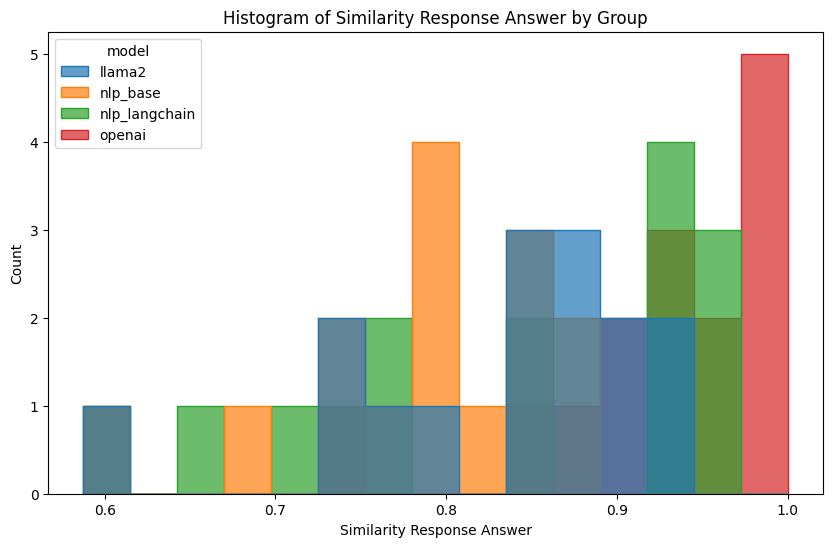

In [51]:
plt.figure(figsize=(10, 6))
sns.histplot(data=res, x='similarity_response_answer', hue='model', element='step', bins=15, alpha=0.7)
plt.title('Histogram of Similarity Response Answer by Group')
plt.xlabel('Similarity Response Answer'); plt.ylabel('Count'); plt.show()

# Responses

Questions

In [36]:
q,a = questions.loc[1,['Question','Answer']]
display(q,a)

'Is the shift to higher interest rates posing challenges to bond issuers?'

'As we near the one-year mark since the Fed funds rate peaked, our analysis suggests the core financial health of the median US investmentgrade company remains robust. Interest coverage ratios, despite a downward trend, are still near or just below historical averages. Sustained economic and earnings growth may enable resilient companies to adjust to a higher rate environment. Higher rates may also encourage a more conservative approach to capital management among corporates, which could bolster credit metrics. While the shift to higher interest rates appears generally manageable, it does pose challenges for some. We believe navigating the new landscape of higher rates and structural shifts demand an active, fundamental approach to bond selection.'

In [37]:
%%time
response, score = openai.answer(q)
print(response)

The shift to higher interest rates appears generally manageable, but it does pose challenges for some bond issuers.
CPU times: user 386 ms, sys: 17.4 ms, total: 404 ms
Wall time: 1.61 s


In [38]:
%%time
response, score = llama2.answer(q)
print(response)

Based on the analysis provided in the given context, it appears that the shift to higher interest rates is not necessarily posing significant challenges to bond issuers. According to Goldman Sachs Asset Management, the core financial health of the median US investment-grade company remains robust, despite a downward trend in interest coverage ratios. The report suggests that sustained economic and earnings growth may enable resilient companies to adjust to a higher rate environment. Additionally, the report notes that higher rates may encourage corporates to adopt more conservative capital management strategies, which could bolster credit metrics. While the shift to higher interest rates may pose challenges for some issuers, the analysis suggests that the impact is likely to be manageable overall.
CPU times: user 165 ms, sys: 962 ms, total: 1.13 s
Wall time: 16.1 s


In [39]:
%%time
response, score = nlp_base.answer(q)
print(response)

# MACROECONOMY: A LONGER PATH TO NORMALIZATION

# Three Key Questions

# 1. Is the shift to higher interest rates posing challenges to bond issuers?

Our View: As we near the one-year mark since the Fed funds rate peaked, our analysis suggests the core financial health of the median US investment-grade company remains robust. Interest coverage ratios, despite a downward trend, are still near or just below historical averages. Sustained economic and earnings growth may enable resilient companies to adjust to a higher rate environment. Higher rates may also encourage a more conservative approach to capital management among corporates, which could bolster credit metrics. While the shift to higher interest rates appears generally manageable, it does pose challenges for some. We believe navigating the new landscape of higher rates and structural shifts demand an active, fundamental approach to bond selection.

# 2. Can small caps finally outperform?

Our View: We think small caps are a coil

In [40]:
%%time
response, score = nlp_langchain.answer(q)
print(response)

# MACROECONOMY: A LONGER PATH TO NORMALIZATION

# Three Key Questions

# 1. Is the shift to higher interest rates posing challenges to bond issuers?



Our View: As we near the one-year mark since the Fed funds rate peaked, our analysis suggests the core financial health of the median US investment-grade company remains robust. Interest coverage ratios, despite a downward trend, are still near or just below historical averages. Sustained economic and earnings growth may enable resilient companies to adjust to a higher rate environment. Higher rates may also encourage a more conservative approach to capital management among corporates, which could bolster credit metrics. While the shift to higher interest rates appears generally manageable, it does pose challenges for some. We believe navigating the new landscape of higher rates and structural shifts demand an active, fundamental approach to bond selection.

# 2. Can small caps finally outperform?
CPU times: user 27.3 ms, sys: 11.5 ms, 

Question 2

In [41]:
q, a = questions.loc[4, ['Question', 'Answer']]
display(q, a)

"What is the key takeaway of Goldman's mid-year outlook 2024?"

'1. Macroeconomy: A Longer Path to Normalization; 2. Geopolitics and Elections: Roadmaps for Resilience; 3. Tailwinds and Headwinds: Investing in Megatrends'

In [42]:
%%time
response, score = openai.answer(q)
print(response)

The key takeaway of Goldman's mid-year outlook 2024 is the importance of active and dynamic investment strategies in response to evolving macroeconomic conditions, geopolitical uncertainties, and the acceleration of secular megatrends shaping economies and industries.
CPU times: user 1.23 s, sys: 219 ms, total: 1.45 s
Wall time: 1.94 s


In [43]:
%%time
response, score = llama2.answer(q)
print(response)

The key takeaway of Goldman Sachs Asset Management's mid-year outlook 2024 is investing in megatrends.
CPU times: user 70.9 ms, sys: 132 ms, total: 203 ms
Wall time: 3.39 s


In [44]:
%%time
response, score = nlp_base.answer(q)
print(response)

# Asset Management

# MID-YEAR OUTLOOK 2024

# KEY THEMES

# Macroeconomy:

A Longer Path to Normalization

# Geopolitics and Elections:

Roadmaps for Resilience

# Tailwinds and Headwinds:

Investing in Megatrends

This financial promotion is provided by Goldman Sachs Asset Management B.V.
CPU times: user 19.7 ms, sys: 9.32 ms, total: 29 ms
Wall time: 24.6 ms


In [45]:
%%time
response, score = nlp_langchain.answer(q)
print(response)

Goldman Sachs Asset Management

Asset Management Outlook 2024 | 11

# TAILWINDS AND HEADWINDS:

# INVESTING IN MEGATRENDS



Beyond the near-term path of inflation, rates, and election results, we remain focused on longer-term paradigm shifts, including five key structural forces: decarbonization, digitization, deglobalization, destabilization in geopolitics, and demographic aging. Active investment strategies, a focus on diversification and risk management may become increasingly important to help navigate these contours and deliver alpha. Investors who stay in their silos and focus on a single theme may miss out on opportunities and underestimate risks.
CPU times: user 20.8 ms, sys: 6.99 ms, total: 27.8 ms
Wall time: 27.1 ms
